# Quick recap

To get started, we need to make sure we have the right packages. The packages for surrogate construction and plotting is `tesuract` and `clif`. `tesuract` can be downloaded using `pip install tesuract` or getting the source from [here](https://github.com/kennychowdhary/tesuract). `clif` is a private repo and you should have got an invitation to be a collaborator. The link is [here](https://github.com/kennychowdhary/clif). We will use `clif` for plotting and some preprocessing transforms, but it is not required. 

These packages, and other will require the following third party libraries:

```
xarray
dask
numpy 
matplotlib
netcdf4
scikit-learn
cartopy (optional)
```

Once you have all those packages installed, we can begin loading and plotting the data. 

## Understanding the data

The data is saved as a netcdf file, which is similar to a pandas style data frame. We will load is as an xarray data set which will allow us to load a whole bunch of meta data along with the numpy arrays. For example, the data sets we will be looking at are latitude-longitude fields. If we were to import the data as a pure numpy array, we would lose the latitude or longitude indices associated with each row and column of the data set. xarray allows us to store that information. It is a mix between pandas and numpy, and it becoming increasingly utilized in the climate world. 

The data sets are broken up by seasons (DJF - December, January, February). So for DJF/ winter, we have two separate `*.nc` files or netcdf files. `lat_lon_10yr_24x48_DJF.nc` contains simulation data from 250 independent runs of E3SM. It contains different climatologies or outputs of the model such as shortwave and longwave cloud forcing, and total precipitation. Let's see how to load this data and what it looks like. 

In [1]:
import numpy as np
import xarray as xr
import dask

In [2]:
# open the data set and load it via chunks (dask) for efficient handling (optional)
season = 'DJF' # season
dataset = xr.open_mfdataset(f"../data/lat_lon_10yr_24x48_{season}.nc", chunks={'n': 1})

For our purposes, we will only need a few of these variables. The variables of interest will be 

```
SWCF (shortwave cloud forcing W/m^2)
LWCF (longwave cloud forcing W/m^2)
PRECT (total precipitation m/day)
area (latitude/ longitude area weights of grids, not equally spaced)
lhs (Latin hypercuve sampling tuning parameters/ feature space samples X)
lhs_bnds (bounds on feature space parameters - for re-scaling)
```

Let's extract the SWCF variable and the LHS points 

In [3]:
# Extract the training data for SWCF
Y = dataset['SWCF']
X = dataset['lhs']
X_bnds = dataset['lhs_bnds']

Now that we extracted the training data, let's explore its shape. The first dimension is always the sampling dimension, as standard in ML. Thus, each row of the dataset corresponds to a different sample

$X$ is of size $250 \times 5$ corresponding to $250$ training samples and $5$-dimensional feature space. Each row represents a different set of parameters and the corresponding E3SM model simulation output is given in $Y$. 

$Y$ is of size $250 \times 24 \times 48$, thus each sample of $Y$ is a $24\times48$ *image* or spatially varying latitude-longitude field. As you can see above, $Y$ is a three dimensional tensor (it's actually 4 but we ignore the time), with latitude and longitude coordinates. 

$(X,Y)$ represent input/ output pairs of the E3SM climate model. We will use this data to creat a regression model that maps/ interpolates $X$ to $Y$. We do this so we can calibrate the climate model, i.e., we want to find the optimal input value such that $Y$ matches some observed climate data. That is, 

$$x^* = \arg \min_{x} \|Y_{\mathrm{E^3SM}}(x) - Y_{\mathrm{obs}} \| $$

Since E3SM is too computationally expensive, instead, we solve 

$$x^* = \arg \min_{x} \|Y_{\mathrm{surrogate}}(x) - Y_{\mathrm{obs}} \| $$, 

where we replace the full model with a machine learning surrogate. This optimization can be solved quickly given that the surrogate is differentiable and easy to evaluate. 

This observed data can be loaded from the corresponding netcdf file from the same data directory.   

In [4]:
# Load the observation or reference data
dataset_obs = xr.open_mfdataset(f"../data/lat_lon_24x48_{season}_obs.nc", chunks={'n': 1})
Y_obs = dataset_obs['SWCF']

## Creating a dummy predictor

Let's create our first surrogate which maps $X \mapsto Y$. The standard baseline or starting point would be to use a mean approximation as a model. Of course, this mean predictor has no dependence on $X$ but if it performs better than a more complex model, then it is a problem. So we always compute the dummy predictor as a default. 

We can use sklearn's dummy regressor to create such a model quite easily. For simplicity, it will help to flatten each of the $24\times 48$ output data sets. 

In [5]:
# Extract numpy array from the xarray.DataArray
Y_np = Y.values
Y_np = np.array([Yi.flatten() for Yi in Y_np])
Y_np.shape

(250, 1152)

In [6]:
# Also, extract the feature matrix as a numpy array
X_np = X.values
X_np.shape

(250, 5)

If you take a look at $X$, it contains vastly different scales. For better performance, we will do some feature scaling and transform the input data to a standard input. We will use tesuract to perform this transformation. To do this we need to extract the bounds from the dataset and then perform a feature transform. 

In [7]:
feature_coords = dataset['x'].values
print("names of the feature coordinates:\n",feature_coords)

feature_bounds = dataset['lhs_bnds'].values
print("List of upper and lower bounds:\n", list(feature_bounds))

from tesuract.preprocessing import DomainScaler
feature_transform = DomainScaler(
                dim=X_np.shape[1],
                input_range=list(feature_bounds),
                output_range=(-1,1),
                )
X_s = feature_transform.fit_transform(X_np)
print("Range of scaled features:({0:.3f},{1:.3f})".format(X_s.min(), X_s.max()))

names of the feature coordinates:
 ['ice_sed_ai' 'clubb_c1' 'clubb_gamma_coef' 'zmconv_tau' 'zmconv_dmpdz']
List of upper and lower bounds:
 [array([ 350., 1400.]), array([1., 5.]), array([0.1, 0.5]), array([ 1800., 14400.]), array([-0.002 , -0.0001])]
Range of scaled features:(-1.000,0.998)


### Reduced order modeling using dimension reduction

Since the output is multi-target and high-dimensional, it may be beneficial to perform dimension reduction to project the target data onto a lower-dimensional latent or *hidden* feature space. We can do this with principal component analysis using sklearn. Computationally, this process is very efficient since it only requires an SVD and matrix transpose to transform the high-dimensional space to the latent space, and vice versa. 

Text(0.5, 1.0, 'Cumulative explained ratio')

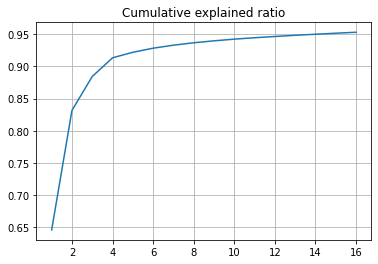

In [14]:
# Re-label the data to X and Y
X = X_s.copy()
Y = Y_np.copy()

# Import PCA transform from sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components=16,whiten=True)
Yhat = pca.fit_transform(Y)

# We can plot the explained variance which shows how much of the total variance the PCA components capture
import matplotlib.pyplot as plt
evr = pca.explained_variance_ratio_
plt.plot(range(1,len(evr)+1),np.cumsum(evr))
plt.grid(True)
plt.title("Cumulative explained ratio")


From this plot, it looks like 12 components are enough to capture ~95% of the total variance. Try this for PRECT. 

So now instead of fitting $X \mapsto Y$, we can fit $X \mapsto \hat{Y}$ and then transform $\hat{Y} \mapsto Y$. The complete model can be combined using the Pipeline mechanism in sklearn. In keras or Pytorch, we can add a final layer to the neural network that is a matrix transpose to perform the PCA inverse transform. 

In [16]:
print(Y.shape, "vs ", Yhat.shape)

(250, 1152) vs  (250, 16)


## Bayesian Neural Networks

Principal component analysis is actually a statistical technique (probabilistic version of a Fourier series) based on a theory known as the Karhunen-Loeve expansion. The idea is that any stochastic process, e.g., time series like Brownian motion, can be written as a linear combination of basis functions (principal components), where the projection of the data onto those components are themselves random variables. That is, 

$$ X(t) = \sum_{i=1}^k Z_i \Phi_i(t)$$,

where $Z_k$ is a random variabel whose distribution is given by $\Phi_i(t) \cdot X(t)$. The $\Phi(t)$ are actually the eigenfunctions associated with the covariance function/ kernel of the stochastic kernel. It turns out that for any Gaussian process, $Z_i$ are univariate Gaussian random variables (standard normal if we divide by the square root of the eigenvalues of the associated eigenvectors). Also, WLOG, $t$ can be time, but it can also be any d-dimensional set and we can always vectorize the data into an ordered vector, e.g., flattening the data. 

The point being is that if we are trying to create a surrogate map between $x$ and $\hat{Y}$, where $\hat{Y}$ is the PCA projection coefficients, the output is actually inherently stochastic. Thus, if we build a deterministic map between $X \mapsto \hat{Y}$ it only tells half the story. Instead, it might be beneficial to try a fit a Bayesian model to the data, which gives us a probabilistic model of the projection coefficients. 

To see what the distribution of these projection coefficients look like, let's plot the first 12 component histograms.

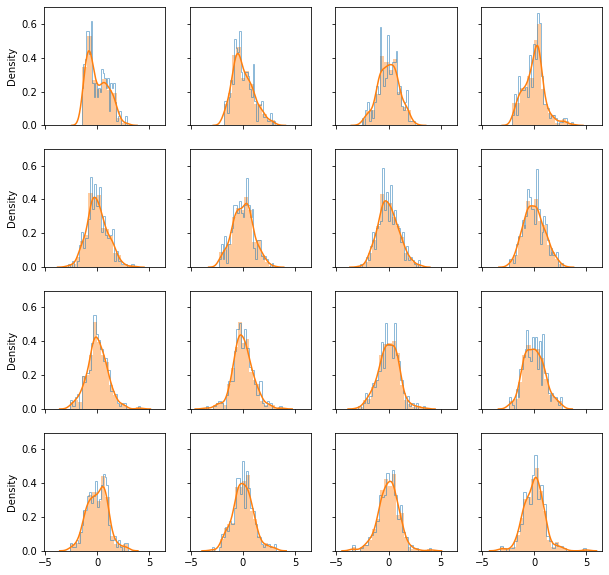

In [44]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
fig, axes = plt.subplots(4,4,figsize=[10,10],sharex=True,sharey=True)
for j,ax in enumerate(axes.flatten()):
    ax.hist(Yhat[:,j],bins=30,density=True,histtype='step',alpha=.5)
    sns.distplot(Yhat[:,j],ax=ax)